In [52]:
import torch 
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
# # p et q sont deux listes de vecteru de taille n représentant les probas conditionelles
#     # ATTENTION en sortie du réseau de neurones, on a un vecteur de taille n
#     # en effet, on  a besoin des probas conditionelles pour chaque i. Donc, on ne peut pas demander au réseau de 
#     # sortir direct la proba q_theta(s)
#     # Donc, c'est dans la fonction loss qu'on va convertir ces probas conditionelles en proba d'observer s (par une simple multiplication)
#     probasp=[]
#     probasq=[]
#     for pi in p:
#         res=1
#         for i in pi:
#             res*=i
#         probasp.append(res)
#     for qi in q:
#         res=1
#         for i in qi:
#             res*=i
#         probasq.append(res)

In [118]:
def Kulback_Leibler(q,p): # p et q sont des listes de probas d'observation des mêmes s
    for i in range(len(p)):
        if p[i] == 0:
            p[i] = 1e-10
    result = 0 
    for i in range(len(p)):
        result += q[i]*np.log(q[i]/p[i])
    return result

In [120]:
a=torch.tensor([0.1,0.2,0.3,0.4])
b=torch.tensor([0.25,0.25,0.25,0.25])
Kulback_Leibler(b,b)

tensor(0.)

In [6]:


def train(models, q , p_0,   n_iter=100, lr=1e-2):
    nombre_de_neurones=len(models)
    optimizers=[torch.optim.Adam(models[i].parameters(), lr=lr) for i in range(nombre_de_neurones)]
    p=p_0
    for epoch in range(n_iter):
        p='...'# à compléter
        for i in range(nombre_de_neurones):
            optimizers[i].zero_grad()
            loss=Kulback_Leibler(p, q)
            loss.backward()
            optimizers[i]
           


In [ ]:

def train(model, n_iter=100, lr=1e-2):
    plt.figure(figsize=(20, 8))
    axs = [plt.subplot(2, 5, i) for i in range(1, 11)]
    losses = []
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # What is Adam? Which other simpler optimizers can you use?

    for epoch in range(n_iter):
        optimizer.zero_grad() # What is this step? IMPORTANT LINE
        loss = loss_fn(model(x_train), y_train)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
       
        if epoch % (n_iter/10) == 0:
            print(f'Epoch {epoch}: {loss.item()}')

            # plot progress
            ax_index = int(epoch // (n_iter/10))
            plt.sca(axs[ax_index])
            plt.plot(x_grid, target(x_grid), label='target')
            plt.plot(x_grid, grab(model(x_grid)).squeeze(), label='model init')
            
    return losses




def loss_fn(y_pred, y_true):
    return torch.mean((y_pred - y_true) ** 2)

In [39]:
n=4
M = torch.zeros((n, n), dtype=torch.int)  # Crée une matrice de zéros de taille n x n
        
for i in range(n):
    for j in range(i, n):
        M[i][j] = 0

# Remplit la partie inférieure de la diagonale avec des uns
for i in range(1, n):
        for j in range(i):
                M[i][j] = 1

In [44]:
A=torch.tensor([[1, 2], [3, 4]])

In [48]:
class MaskedLinear(nn.Linear):
    def __init__(self, in_features, out_features, mask, bias=True):
        super(MaskedLinear, self).__init__(in_features, out_features, bias)
        self.mask = mask

    def forward(self, input):
        return nn.functional.linear(input, self.weight * self.mask, self.bias)

In [54]:
torch.sigmoid(torch.tensor([0.0, 2.0]))

tensor([0.5000, 0.8808])

In [50]:
class VAN(nn.Module):
    def __init__(self, input_size, activation=torch.sigmoid):
        super(VAN, self).__init__() #initialisation obligatoire
        self.input_size = input_size

        # Création de la matrice de masque : que des 0 sur et au dessus de la diagonale et que des 1 dessous
        M = torch.zeros((input_size, input_size), dtype=torch.int)
        for i in range(input_size):
            for j in range(i, input_size):
                M[i][j] = 0
        for i in range(1, input_size):
            for j in range(i):
                M[i][j] = 1

        self.fc1 = MaskedLinear(input_size, input_size, mask=M)
        self.activation = activation

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        # à cette ligne on a multiplié x par la matrice de masque (triangulaire inférieure), puis appliqué la fonction d'activation
        # donc la première coordonnée de x vaut activation(0) (normal, s^_1 ne dépend de personne)
        # il faut donc ajouter 0.5 à la première coordonnée pour montrer qu'elle vaut 0 et 1 avec proba 0.5
        x[0] = 0.5
        return x


In [113]:
train_set=torch.zeros((5, 2))
# 5 points de taille 2
print(train_set)
train_set[0][0]=torch.bernoulli(torch.tensor(0.5))
print(train_set)

tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]])
tensor([[1., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]])


In [114]:
torch.tensor([1, 2, 3, 4, 5])

tensor([1, 2, 3, 4, 5])

In [ ]:
def train(model, p_obj,  n_iter=100, lr=1e-2, train_size=100):

    losses = []

    # p_obj est la distribution à approximer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    losses = []
    # il faut tirer un train_set grâce au modèle pour s'entraîner dessus
    train_set=torch.zeros((train_size, model.input_size))
    for i in range(train_size):
        # pour tirer un x dans x_train, on tire une bernoulli de paramètre 0.5 : c'est s_1
        # comment avoir s_2 ? ON fait passer le vecteur [s_1, 0, 0, 0] dans le réseau de neurones
        # en sortie du réseau de neurones, on a y =[ s1 randomn, p(s2|s1), p(s3|s1), p(s4|s1)...]
        # la deuxième coordonnée de y est p(s2|s1), donc on tire une bernoulli de paramètre p(s2|s1)
        # puis on recommence !
        # on fait ça train_size fois
        train_set[i][0]=torch.bernoulli(torch.tensor(0.5))
        for j in range(1, model.input_size):
            y_pred=model(train_set[i])
            p_j= y_pred[j] # c'est p(s_j|s_{i<j})
            train_set[i][j]=torch.bernoulli(torch.tensor(p_j)) # on tire une bernoulli de paramètre p(s_j|s_{i<j}) pour la j-ème variable
    
    y_train=torch.tensor([p_obj(s) for s in train_set])
    # à cette étape, on a un train set, on peut entraîner le modèle
    for epoch in range(n_iter):
        optimizer.zero_grad() # What is this step? IMPORTANT LINE
        listes_de_probas_conditionelles=model(train_set) # on récupère les probas conditionelles, il faut les multiplier pour avoir les probas tout court
        q_theta_predit=[]
        for proba_conditionelle in listes_de_probas_conditionelles:
            res=1
            for i in proba_conditionelle:
                res*=i
            q_theta_predit.append(res)
        # c'est bon on a les probas, on peut appliquer DKL
        loss = Kulback_Leibler(torch.tensor(q_theta_predit), y_train)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if epoch % (n_iter/10) == 0:
            print(f'Epoch {epoch}: {loss.item()}')
    return losses

            
            


In [81]:
torch.sigmoid(torch.tensor([0.5, 2.0]))


tensor([0.6225, 0.8808])

In [49]:
n=7
M = torch.zeros((n, n), dtype=torch.int)  # Crée une matrice de zéros de taille n x n

for i in range(n):
    for j in range(i, n):
        M[i][j] = 0

# Remplit la partie inférieure de la diagonale avec des uns
for i in range(1, n):
        for j in range(i):
                M[i][j] = 1


In [ ]:

class MLP(nn.Module):
    """
    a MLP class inheriting from the parent class nn.Module. 
    nn.Module is the generic parent class of models in Pytorch.
    It requires a method called forward. 
    
    Pytorch will be able to recursively recover all parameters of the
    attributes of a nn.Module object provided the attributes have themselves
    type nn.Modules or nn.ModuleList.

    In this implementation we explicitly specify the scale of initialization 
    of the weight matrices.
    """
    def __init__(self, layerdims, activation=torch.relu, out_activation=None, init_scale=1):
        super(MLP, self).__init__()

        self.layerdims = layerdims
        self.activation = activation
        self.out_activation = out_activation

        linears = [
            nn.Linear(layerdims[i], layerdims[i + 1]) for i in range(len(layerdims) - 1)
        ]

        if init_scale is not None:
            for l, layer in enumerate(linears):
                torch.nn.init.normal_(
                    layer.weight, std=init_scale / np.sqrt(layerdims[l])
                )
                torch.nn.init.zeros_(layer.bias)

        self.linears = nn.ModuleList(linears)

    def forward(self, x):
        layers = list(enumerate(self.linears))
        for _, l in layers[:-1]:
            x = self.activation(l(x))
        y = layers[-1][1](x)
        if self.out_activation is not None:
            y = self.out_activation(y)
        return y



In [126]:
False in torch.tensor([1, 2, 3, 4, 5])==torch.tensor([1, 2, 3, 4, 5])

False

ValueError: only one element tensors can be converted to Python scalars

In [11]:
torch.eq(torch.tensor([1, 2, 3, 4, 5]), torch.tensor([1, 2, 3, 4, 5])).all().item()

True

In [9]:
p= torch.tensor([0.1, 0.2, 0.3, 0.4])
q= torch.tensor([0.25, 0.25, 0.25, 0.25])
Kulback_Leibler(p, p)



tensor(0.)

In [1]:
from VAN import *
import matplotlib.pyplot as plt
taille=6
def p(s):
    if torch.eq(s, torch.tensor([1, 1, 1, 0, 0, 0])).all().item():
        return 0.5
    elif torch.eq(s, torch.tensor([0, 0, 0, 1, 1, 1])).all().item():
        return 0.5
    else:
        return 0
    
def p2(s):
    return 1/(2**6)

model=VAN(taille, torch.sigmoid)

l=train(model, p, n_iter=100, lr=1e-1, train_size=30)

Epoch 0: 497.21978759765625
Epoch 10: 519.7166137695312
Epoch 20: inf
Epoch 30: 520.9984741210938
Epoch 40: 520.3217163085938
Epoch 50: inf
Epoch 60: inf
Epoch 70: inf
Epoch 80: 497.7961120605469
Epoch 90: 473.74334716796875


In [8]:
l


[-0.6969754099845886,
 -0.6694832444190979,
 -0.678429365158081,
 -0.7220017313957214,
 -0.6894797682762146,
 -0.6848087310791016,
 -0.6867111325263977,
 -0.6920499205589294,
 -0.6663811206817627,
 -0.658984899520874]

In [6]:
torch.bernoulli(torch.tensor(0.5))

tensor(0.)

In [20]:
type(torch.bernoulli(torch.tensor(0.6).detach()))

torch.Tensor

In [22]:
type(torch.tensor(float(np.random.binomial(1, 0.5))))

torch.Tensor

In [6]:
x=torch.tensor([1, 2, 3, 4, 5]).float()
modified_x = x.clone()  # Create a copy of x to avoid modifying the original tensor
modified_x[0] = 0.5 
modified_x

tensor([0.5000, 2.0000, 3.0000, 4.0000, 5.0000])

In [4]:
torch.sum(torch.tensor([1, 2, 3, 4, 5]).float())

tensor(15.)

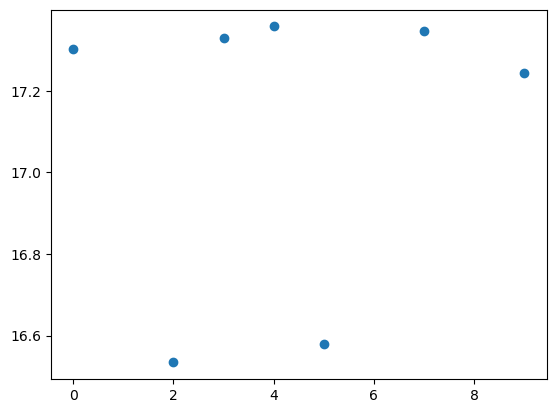

In [4]:
plt.plot(l, 'o')